# WWW: Who Will Win?

## 12 April, 2018

"It's tough to make predictions, especially [about](https://en.wikiquote.org/wiki/Yogi_Berra)  [the](https://en.wikiquote.org/wiki/Niels_Bohr) future." That's true for the **NBA basketball playoffs**, where there is a wide range of opinion about the Warriors and Cavs, the teams that met in the finals each of the last three years. The Las Vegas oddsmakers  have the Warriors as co-favorites at 35% chance to win the title, while  [538](https://fivethirtyeight.com/features/the-nba-playoffs-sleepers-favorites-and-best-first-round-matchups/), using their ELO rating, give the Warriors only a 4% chance. That 9-fold difference underscores that rational people can use different models with different assumptions and come to different conclusions. One important way that models can vary is in their level of abstraction, or level of detail that they cover. Are we better using a general impression, or using specific low-lwvel statistics and aggregating them? Here are some models you might choose:

1. **Holistic**: I just feel that the Warriors have about a 1 in 5 chance of winning it all.
2. **Game by Game**: I think the Warriors have an 75% chance of winning each game in the first round, then 65% for each game in the second round, but only 45% against the Rockets, then 55% if they make it to the finals. From that I'll calculate their overall chance.
3. **Point by Point**: The Warriors have a per-game average point differential of +5.8; I'll compare that to the other teams and caclulate their overall chance.
4. **Play by Play**: Use [detailed statistics](https://www.basketball-reference.com/play-index/plus/shot_finder.cgi) to [model](https://danvatterott.com/blog/2016/06/16/creating-videos-of-nba-action-with-sportsvu-data/) the game shot-by-shot, or even pass-by-pass. That's too complex for me.

# Point by Point Model

The [Simple Rating System](https://www.sportingcharts.com/dictionary/nba/simple-rating-system-statistics.aspx) (SRS) records the average point differential of a team over the season, with a slight adjustment for strength of schedule.  We can look up the winning percentage and SRS of the top contending teams  [here](https://www.basketball-reference.com/leagues/NBA_2018.html) (and other sites have slightly different ways of making similar calculations): 

     TEAM      PCT  SRS
     Rockets  .793  8.2
     Raptors  .720  7.3
     Warriors .707  5.8
     Sixers   .634  4.3
     

The Point-by-Point model says: a game is decided by a random sample from the distribution of point differentials, which is a normal (Gaussian) distribution centered around the difference of SRS scores of the two teams. So, if the Raptors play the Sixers, then the
mean of this distribution is 7.3 - 4.3 = 3.0. We also need to know the standard deviation of the distribution; [Betlabs](https://www.betlabssports.com/blog/a-look-at-nba-team-totals/) says it
is 10.5 points across the NBA (and they confirm that scores roughly follow a normal  distribution). 
The function `simulate` does the calculation by Monte Carlo simulation:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from statistics import mean
from random import gauss

def simulate(diff, 𝝈=10.5, n=100000):
    "Given SRS point differential of a team against another, return game win probability."
    return mean(gauss(diff, 𝝈) > 0 for game in range(n))

In [2]:
simulate(7.3 - 4.3) # Raptors game win probability vs Sixers

0.61325

The model says the Raptors have a 61% chance of beating the Sixers in a single game. 



# Game by Game Model

The next model says that a playoff series is a sequence of independent and identically distributed game results (where the probability of a single-game win could be specified using point differential, or holistically, or some other model). The idea here is to be consistent: if you believe that a team's win percentage is 60%, and you believe that games are independent, then you must believe that the team's chance of wining 4 in a row is 0.6<sup>4</sup> = 0.1296. This model ignores the fact that games aren't strictly independent, and ignores home court advantage. Why? Because these factors would change the final winning estimate by only a few percentage points, and I already have more uncertainty than that.

The function `win_series` calculates the probability of winning a series, given the probability of winning a game:

In [3]:
def win_series(p, W=0, L=0):
    """Probability of winning best-of-7 series, given a probability p of winning a game.
    The optional arguments say how many Wins and Losses the team has in the series so far."""
    return (1 if W == 4 else
            0 if L == 4 else
            p       * win_series(p, W + 1, L) + 
            (1 - p) * win_series(p, W, L + 1))

We can make a table:

In [4]:
for diff in range(10):
    g = simulate(diff)
    print('{} point differential = {:4.0%} win game = {:4.0%} win series'.format(
          diff, g, win_series(g)))

0 point differential =  50% win game =  50% win series
1 point differential =  54% win game =  58% win series
2 point differential =  58% win game =  67% win series
3 point differential =  61% win game =  73% win series
4 point differential =  65% win game =  80% win series
5 point differential =  68% win game =  85% win series
6 point differential =  72% win game =  89% win series
7 point differential =  75% win game =  93% win series
8 point differential =  78% win game =  95% win series
9 point differential =  81% win game =  97% win series


With a zero point differential obnviously you're at 50% win percententage; with a 3 point differential you're at 61% to win a game, and 73% to win the series. This agrees very well with the "Differential vs. Win Percentage" [chart](http://a.espncdn.com/combiner/i?img=%2Fphoto%2F2018%2F0408%2F180408_differential.png&w=1140&cquality=40) on [this page](http://www.espn.com/nba/story/_/id/23071005/kevin-pelton-weekly-mailbag-including-nba-all-offensive-teams). 

What happens if some games in a series have already been played? The following function prints a table where each row tells a team's current win-loss record, each column is the game win percentage, and each entry in the table is the series win percentage.

In [5]:
pct = '{:4.0%}'.format 

def series_table(pcts=[p/100 for p in range(15, 90, 5)]):
    print('W-L | Game Win Percentage')
    print('    | ' + ' '.join(map(pct, pcts)))
    for W in range(4):
        print('----+' + '-' * 5 * len(pcts))
        for L in range(4):
            results = [win_series(p, W, L) for p in pcts]
            print('{}-{} | {}'.format(W, L, ' '.join(map(pct, results))))

series_table()

W-L | Game Win Percentage
    |  15%  20%  25%  30%  35%  40%  45%  50%  55%  60%  65%  70%  75%  80%  85%
----+---------------------------------------------------------------------------
0-0 |   1%   3%   7%  13%  20%  29%  39%  50%  61%  71%  80%  87%  93%  97%  99%
0-1 |   1%   2%   4%   7%  12%  18%  26%  34%  44%  54%  65%  74%  83%  90%  95%
0-2 |   0%   1%   2%   3%   5%   9%  13%  19%  26%  34%  43%  53%  63%  74%  84%
0-3 |   0%   0%   0%   1%   2%   3%   4%   6%   9%  13%  18%  24%  32%  41%  52%
----+---------------------------------------------------------------------------
1-0 |   5%  10%  17%  26%  35%  46%  56%  66%  74%  82%  88%  93%  96%  98%  99%
1-1 |   3%   6%  10%  16%  24%  32%  41%  50%  59%  68%  76%  84%  90%  94%  97%
1-2 |   1%   3%   5%   8%  13%  18%  24%  31%  39%  48%  56%  65%  74%  82%  89%
1-3 |   0%   1%   2%   3%   4%   6%   9%  12%  17%  22%  27%  34%  42%  51%  61%
----+---------------------------------------------------------------------------
2-

For example, if our team with a 60% game win percentage loses the first game of the series, check the "0-1" row and the "60%" column to see that it still has a 54% chance of winning the series. 

We can also do plots:

In [6]:
diff = [d/10 for d in range(100)]
game = [simulate(d) for d in diff]
series = [win_series(p) for p in game]

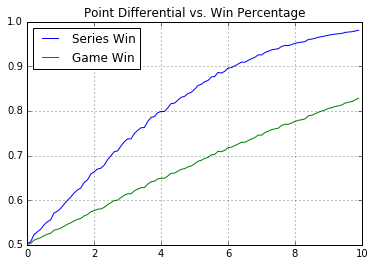

In [7]:
plt.plot(diff, series, label='Series Win')
plt.plot(diff, game, label='Game Win')
plt.legend(loc='best');
plt.grid()
plt.title('Point Differential vs. Win Percentage');

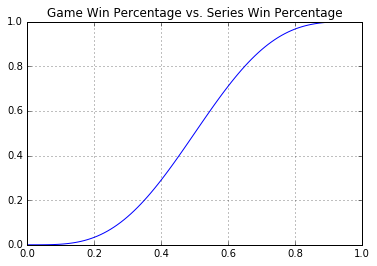

In [8]:
P = [p/100 for p in range(100)]
plt.plot(P, [win_series(p) for p in P])
plt.grid()
plt.title('Game Win Percentage vs. Series Win Percentage');

# Series by Series Model

Here's a function to tabulate a team's chance of winning each series on the way to a title. The first argument is the team's name, and each following argument is a playoff round entry, consisting of the opponent team name, the game win percentage against this opponent, and optionally the wins and losses in the series so far:

In [9]:
def playoffs(name, *rounds):
    "Print probability for team winning each series."
    overall = 1.0 
    for (opponent, p, *WL) in rounds:
        this_round = win_series(p, *WL)
        overall *= this_round
        print('{} vs {:8} {}; through here: {}'
              .format(name, opponent, pct(this_round), pct(overall)))

Here my holistic game estimates are turned into overall predictions:

In [10]:
playoffs('Rockets',
         ('Wolves',   0.75),
         ('Jazz',     0.70),
         ('Warriors', 0.55),
         ('Raptors',  0.60))

Rockets vs Wolves    93%; through here:  93%
Rockets vs Jazz      87%; through here:  81%
Rockets vs Warriors  61%; through here:  49%
Rockets vs Raptors   71%; through here:  35%


In [11]:
playoffs('Warriors',
         ('Spurs',   0.75),
         ('Blazers', 0.65),
         ('Rockets', 0.45),
         ('Raptors', 0.55))

Warriors vs Spurs     93%; through here:  93%
Warriors vs Blazers   80%; through here:  74%
Warriors vs Rockets   39%; through here:  29%
Warriors vs Raptors   61%; through here:  18%


So I'm in good agreement with the Vegas oddsmakers about the Rockets: I have the Rockets at 49% winning the conference and 35% winning the title, while Vegas had them at  44% and 35%. For the Warriors I'm splitting the difference between 538's low estimate (8% win conference, 4% win title) and Vegas's high estimate (44% and 35%, tied with the Rockets).

What if I went by point differential?

In [12]:
playoffs('Rockets',
         ('Wolves',   simulate(8.2 - 2.3)),
         ('Jazz',     simulate(8.2 - 4.5)),
         ('Warriors', simulate(8.2 - 5.8)),
         ('Raptors',  simulate(8.2 - 7.3)))

Rockets vs Wolves    88%; through here:  88%
Rockets vs Jazz      78%; through here:  69%
Rockets vs Warriors  69%; through here:  48%
Rockets vs Raptors   57%; through here:  27%


In [13]:
playoffs('Warriors',
         ('Spurs',   simulate(5.8 - 2.9)),
         ('Blazers', simulate(5.8 - 2.6)),
         ('Rockets', simulate(5.8 - 8.2)),
         ('Raptors', simulate(5.8 - 7.3)))

Warriors vs Spurs     73%; through here:  73%
Warriors vs Blazers   75%; through here:  55%
Warriors vs Rockets   31%; through here:  17%
Warriors vs Raptors   37%; through here:   6%


This model cuts the Rockets' chances a bit (mainly because the Raptors have a strong 7.3 score), and cuts the Warriors' chances a lot, bringing them more in line with the 538 prediction. How do I reconcile the discrepancy between my subjective probabilities and these numbers? I guess I would say that I  have  less faith in the point differential model, for several reasons: it counts games from the distant past, when some teams had very different lineups than they have now (due to injuries and trades); different teams have different approaches to how they handle games whose outcome is already decided; the metric puts too much emphasis on blowouts, for example, in the Warriors' final game, it was to their strategic advantage to lose, and they did it very convincingly&mdash;by 40 points, which dropped their average point differential for the entire year by 0.5 points.

# Series Length

Given a team's game win percentage, how many games should we expect a series to run? That is, with a game win percentage of 60%, how likely is it to sweep all 4 games? To go to 7 games? Here's a chart of the probability of each possible series outcome, based on the win percentage of the first team:

In [14]:
import collections

class MCounter(collections.Counter):
    "A multipliable Counter: you can say `2 * MCounter(stuff)`."
    def __mul__(self, p): return MCounter({k: p * self[k] for k in self})
    __rmul__ = __mul__

In [15]:
def series_results(p, W=0, L=0) -> MCounter:
    """Return {(win, loss): probability} for all possible outcomes of the series."""
    return MCounter([(W, L)] if W == 4 or L == 4 else
                    (p       * series_results(p, W + 1, L) + 
                     (1 - p) * series_results(p, W, L + 1)))
            
def series_results_table(pcts=[p/100 for p in range(10, 95, 5)]):
    outcomes = [(4, 0), (4, 1), (4, 2), (4, 3), (3, 4), (2, 4), (1, 4), (0, 4)]
    print('W-L | Game Win Percentage')
    print('    | ' + ' '.join(map(pct, pcts)))
    print('----+'  + '-' * 5 * len(pcts))
    for (W, L) in outcomes:
        results = [series_results(p)[W, L] for p in pcts]
        print('{}-{} | {}'.format(W, L, ' '.join(map(pct, results))))

series_results_table()

W-L | Game Win Percentage
    |  10%  15%  20%  25%  30%  35%  40%  45%  50%  55%  60%  65%  70%  75%  80%  85%  90%
----+-------------------------------------------------------------------------------------
4-0 |   0%   0%   0%   0%   1%   2%   3%   4%   6%   9%  13%  18%  24%  32%  41%  52%  66%
4-1 |   0%   0%   1%   1%   2%   4%   6%   9%  12%  16%  21%  25%  29%  32%  33%  31%  26%
4-2 |   0%   0%   1%   2%   4%   6%   9%  12%  16%  19%  21%  22%  22%  20%  16%  12%   7%
4-3 |   0%   1%   2%   3%   6%   8%  11%  14%  16%  17%  17%  15%  13%  10%   7%   4%   1%
3-4 |   1%   4%   7%  10%  13%  15%  17%  17%  16%  14%  11%   8%   6%   3%   2%   1%   0%
2-4 |   7%  12%  16%  20%  22%  22%  21%  19%  16%  12%   9%   6%   4%   2%   1%   0%   0%
1-4 |  26%  31%  33%  32%  29%  25%  21%  16%  12%   9%   6%   4%   2%   1%   1%   0%   0%
0-4 |  66%  52%  41%  32%  24%  18%  13%   9%   6%   4%   3%   2%   1%   0%   0%   0%   0%


So we see that our 60% team has a 13% chance of sweeping (4-0), and 13+21+21 = 55% chance of winning in 6 games or less.

**Note:** I had to define `MCounter` because `collections.Counter` does not support multiplication. I think it should: if `C` is a `Counter`, then shouldn't `C + C` be the same as `2 * C`?

---

# Historical Relic: 2016 NBA Playoffs


## 18 April 2016

The Golden State Warriors have had a historic basketball season, winning more games than any other team ever has. But will they top that off by winning the championship? There are 15 other teams in contention, including one, the Spurs, that has had a historic season as the best second-best team ever. The web site fivethirtyeight, using a complicated scoring system, [gives](http://projects.fivethirtyeight.com/2016-nba-picks/) the Warriors a 44% chance of winning, with the Spurs at 28%. Basketball-reference [has](http://www.basketball-reference.com/friv/playoff_prob.cgi) the Warriors at 41% and Spurs at 32.5%, while a [betting site](http://www.oddsshark.com/nba/nba-futures) had the Warriors at 54% and Spurs at 18%. 
  
Here are the top four teams with their stats:

     TEAM         PCT    SRS
     Warriors    .890  10.38
     Spurs       .817  10.28
     Thunder     .671   7.09
     Cavaliers   .695   5.45

I came up with my own subjective game winning percentages, informed by SRS calculations, plus injury status, etc.
# WWW: Will Warriors Win?


In [16]:
playoffs('Warriors',
         ('Rockets',  0.83),
         ('Clippers', 0.73),
         ('Spurs',    0.58),
         ('Cavs',     0.67))

Warriors vs Rockets   98%; through here:  98%
Warriors vs Clippers  91%; through here:  89%
Warriors vs Spurs     67%; through here:  60%
Warriors vs Cavs      83%; through here:  50%


In [17]:
playoffs('Spurs',
         ('Memphis',  0.83),
         ('Thunder',  0.62),
         ('Warriors', 0.42),
         ('Cavs',     0.67))

Spurs vs Memphis   98%; through here:  98%
Spurs vs Thunder   75%; through here:  73%
Spurs vs Warriors  33%; through here:  24%
Spurs vs Cavs      83%; through here:  20%


In [18]:
playoffs('Cavs',
         ('Pistons', 0.83),
         ('Hawks',   0.60),
         ('Raptors', 0.55),
         ('GSW/SAS', 0.33))

Cavs vs Pistons   98%; through here:  98%
Cavs vs Hawks     71%; through here:  70%
Cavs vs Raptors   61%; through here:  42%
Cavs vs GSW/SAS   17%; through here:   7%


I have the Warriors at 50% (for the estimate of winning it all) and the Spurs at 20%, so I'm more of a Warriors fan than fivethirtyeight and basketball-reference. Interestingly, while fivethirtyeight does not think this year's Warriors are better than the 1995 Bulls, they [do think](http://fivethirtyeight.com/features/the-warriors-still-arent-the-best-team-ever/) the Spurs, Thunder, and Cavs are the best ever second-, third-, and fourth-best teams in a season.

# WWWWC: Will Warriors Win Without Curry?

## 27 April 2016

The Playoff picture has changed! 

We have some results for first-round series, and there have been key injuries to players including Steph Curry, Avery Bradley, Chris Paul, and Blake Griffin. We don't know for sure how long Curry will be out, but here are my updated odds for the Warriors, under the assumption that Curry misses the second round, and comes back in time for the Western Conference Finals at a mildly reduced capacity:

In [19]:
playoffs('Warriors',
         ('Rockets',  0.70, 3, 1),
         ('Blazers',  0.55),
         ('Spurs',    0.55),
         ('Cavs',     0.60))

Warriors vs Rockets   97%; through here:  97%
Warriors vs Blazers   61%; through here:  59%
Warriors vs Spurs     61%; through here:  36%
Warriors vs Cavs      71%; through here:  26%


The Spurs and Cavs are rolling; let's update their odds:

In [20]:
playoffs('Spurs',
         ('Memphis',  0.83, 4, 0),
         ('Thunder',  0.62),
         ('Warriors', 0.45),
         ('Cavs',     0.67))

Spurs vs Memphis  100%; through here: 100%
Spurs vs Thunder   75%; through here:  75%
Spurs vs Warriors  39%; through here:  29%
Spurs vs Cavs      83%; through here:  24%


In [21]:
playoffs('Cavs',
         ('Pistons', 0.83, 4, 0),
         ('Hawks',   0.60),
         ('Raptors', 0.55),
         ('GSW/SAS', 0.40))

Cavs vs Pistons  100%; through here: 100%
Cavs vs Hawks     71%; through here:  71%
Cavs vs Raptors   61%; through here:  43%
Cavs vs GSW/SAS   29%; through here:  13%


So my updated odds are that the Warriors and Spurs are roughly equally likely to win (26% and 24%); the Cavs are still less likely (13%), and there is more uncertainty.



# WWWWCB: Will Warriors Win With Curry Back?

## 10 May 2016

Curry has returned from his injury, and after a slow shooting start, had the highest-scoring overtime period in the history of the NBA. Meanwhile, the Thunder lead the Spurs, 3-2, and the Cavaliers have been dominant in the East, hitting a historic number of 3-point shots. Here is my revised outlook: 

In [22]:
playoffs('Warriors',
         ('Rockets',  0.70, 4, 1),
         ('Blazers',  0.67, 3, 1),
         ('Spurs',    0.60),
         ('Cavs',     0.55))

Warriors vs Rockets  100%; through here: 100%
Warriors vs Blazers   96%; through here:  96%
Warriors vs Spurs     71%; through here:  68%
Warriors vs Cavs      61%; through here:  42%


In [23]:
playoffs('Spurs',
         ('Memphis',  0.83, 4, 0),
         ('Thunder',  0.60, 2, 3),
         ('Warriors', 0.40),
         ('Cavs',     0.50))

Spurs vs Memphis  100%; through here: 100%
Spurs vs Thunder   36%; through here:  36%
Spurs vs Warriors  29%; through here:  10%
Spurs vs Cavs      50%; through here:   5%


In [24]:
playoffs('Thunder',
         ('Dallas',   0.83, 4, 1),
         ('Spurs',    0.40, 3, 2),
         ('Warriors', 0.40),
         ('Cavs',     0.45))

Thunder vs Dallas   100%; through here: 100%
Thunder vs Spurs     64%; through here:  64%
Thunder vs Warriors  29%; through here:  19%
Thunder vs Cavs      39%; through here:   7%


In [25]:
playoffs('Cavs',
         ('Pistons',  0.83, 4, 0),
         ('Hawks',    0.60, 4, 0),
         ('Raptors',  0.65),
         ('GS/SA/OK', 0.45))

Cavs vs Pistons  100%; through here: 100%
Cavs vs Hawks    100%; through here: 100%
Cavs vs Raptors   80%; through here:  80%
Cavs vs GS/SA/OK  39%; through here:  31%


So overall, from the start of the playoffs up to May 10th, I have:

- **Warriors:** Dropped from 50% to 26% with Curry's injury, and rebounded to 42%. 
- **Spurs:** Dropped from 20% to 5% after falling behind Thunder.
- **Thunder:** Increased to 7%.
- **Cavs:** Increased to 31%.

# Time to Panic Yet?

## 17 May 2016

The Thunder finished off the Spurs and beat the Warriors in game 1. Are the Thunder, like the Cavs, peaking at just the right time, after an inconsistant regular season? Is it time for Warriors fans to panic?

Sure, the Warriors were down a game twice in last year's playoffs and came back to win both times. Sure, the Warriors are still 3-1 against the Thunder this year, and only lost two games all season to elite teams (Spurs, Thunder, Cavs, Clippers, Raptors). But the Thunder are playing at a top level. Here's my update, showing that the loss cost the Warriors 5%:

In [26]:
playoffs('Warriors',
         ('Rockets',  0.70, 4, 1),
         ('Blazers',  0.67, 4, 1),
         ('Thunder',  0.63, 0, 1),
         ('Cavs',     0.55))

Warriors vs Rockets  100%; through here: 100%
Warriors vs Blazers  100%; through here: 100%
Warriors vs Thunder   61%; through here:  61%
Warriors vs Cavs      61%; through here:  37%


# Yet!

## 24 May 2016

The Thunder won two in a row (first time the Warriors had lost two in a row all year), putting the Warriors down 3-1. And the Cavs are looking mortal, losing two to the Raptors. So now it looks to me like the Thunder are favorites to win it all:

In [27]:
playoffs('Warriors',
         ('Rockets',  0.70, 4, 1),
         ('Blazers',  0.67, 4, 1),
         ('Thunder',  0.55, 1, 3),
         ('Cavs',     0.55))

Warriors vs Rockets  100%; through here: 100%
Warriors vs Blazers  100%; through here: 100%
Warriors vs Thunder   17%; through here:  17%
Warriors vs Cavs      61%; through here:  10%


In [28]:
playoffs('Cavs',
         ('Pistons',  0.83, 4, 0),
         ('Hawks',    0.60, 4, 0),
         ('Raptors',  0.55, 2, 2),
         ('Thunder',  0.45))

Cavs vs Pistons  100%; through here: 100%
Cavs vs Hawks    100%; through here: 100%
Cavs vs Raptors   57%; through here:  57%
Cavs vs Thunder   39%; through here:  23%


In [29]:
playoffs('Thunder',
         ('Dallas',   0.83, 4, 1),
         ('Spurs',    0.40, 4, 2),
         ('Warriors', 0.45, 3, 1),
         ('Cavs',     0.55))

Thunder vs Dallas   100%; through here: 100%
Thunder vs Spurs    100%; through here: 100%
Thunder vs Warriors  83%; through here:  83%
Thunder vs Cavs      61%; through here:  51%


# The 2016 Finals

## 1 June 2016

The Warriors completed their comeback against the Thunder, putting them in a great position to win this year (and they are already established as [favorites for next year](http://www.foxsports.com/nba/story/golden-state-warriors-title-favorites-cleveland-cavaliers-odds-2016-17-053016)). Rather than update the odds after each game of the finals, I'll just repeat the table (with the note that I think the Warriors are somewhere in the 60% range for each game and thus about 70% to win the finals):


In [30]:
series_table()

W-L | Game Win Percentage
    |  15%  20%  25%  30%  35%  40%  45%  50%  55%  60%  65%  70%  75%  80%  85%
----+---------------------------------------------------------------------------
0-0 |   1%   3%   7%  13%  20%  29%  39%  50%  61%  71%  80%  87%  93%  97%  99%
0-1 |   1%   2%   4%   7%  12%  18%  26%  34%  44%  54%  65%  74%  83%  90%  95%
0-2 |   0%   1%   2%   3%   5%   9%  13%  19%  26%  34%  43%  53%  63%  74%  84%
0-3 |   0%   0%   0%   1%   2%   3%   4%   6%   9%  13%  18%  24%  32%  41%  52%
----+---------------------------------------------------------------------------
1-0 |   5%  10%  17%  26%  35%  46%  56%  66%  74%  82%  88%  93%  96%  98%  99%
1-1 |   3%   6%  10%  16%  24%  32%  41%  50%  59%  68%  76%  84%  90%  94%  97%
1-2 |   1%   3%   5%   8%  13%  18%  24%  31%  39%  48%  56%  65%  74%  82%  89%
1-3 |   0%   1%   2%   3%   4%   6%   9%  12%  17%  22%  27%  34%  42%  51%  61%
----+---------------------------------------------------------------------------
2-

# 20 June 2016 

Congratulations to LeBron and the Cavs for overcoming long odds to win a championship for Cleveland. My model says the Warriors were at 94% when they were up 3-1, and if you go by point differential, almost 97%:

In [31]:
win_series(simulate(10.38 - 5.45), W=3, L=1)

0.968211263722248